In this notebook we use an age- and household-structured model to assess the impact of external quarantining as a mitigation measure against covid-19. We compare against the more typical internal quarantine approach. Under external quarantining, a single infected individual is removed from the household and has no interaction with the members of that household or any other. Under internal quarantining, the infected individual is still able to interact with the other members of their household but the entire household is completely prevented from contributing to the population-level outbreak.

In [1]:
from os.path import isfile
from pickle import load, dump
from numpy import arange, array
from numpy.random import rand
from pandas import read_csv
from time import time as get_time
from scipy.integrate import solve_ivp
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from model.preprocessing import TwoAgeWithVulnerableInput, HouseholdPopulation
from model.preprocessing import add_vulnerable_hh_members, make_initial_SEPIRQ_condition
from model.specs import SEPIRQ_SPEC
from model.common import SEPIRQRateEquations, within_household_SEPIRQ
from model.imports import ( FixedImportModel)

Check we are in the correct working directory. It needs to be the main repo directory, i.e. ...\User\...\GitHub\covid-19-in-households-public.

In [2]:
from os import getcwd
print(getcwd())

C:\Users\Joe Hilton\Documents\GitHub\covid-19-in-households-public


We first define a set of parameters. The age-specific shedding rates are given by $R_0$ time $\gamma$ time 'sus', i.e. if any class has susceptibility 1, the shedding rate is the standard $\beta=R_0*\gamma$. This is still multiplied through by the age-structured contact matrices to do the actual transmission rates, so to preserve the reproductive ratio at the value specified I think you need to divide sus by the eigenvalue of k_all.

In [3]:
SEPIRQ_SPEC = {
    # Interpretable parameters:
    'R0': 2.4,                      # Reproduction number
    'gamma': 0.5,                   # Recovery rate
    'alpha_1': 0.2,                   # E->P incubation rate
    'alpha_2': 1,                   # P->I prodromal to symptomatic rate
    'tau': array([0.5,0.5,0.5]),           # Prodromal transmission intensity relative to full inf transmission
    'sus': array([1,1,1]),                 # Relative susceptibility by age/vulnerability class
    'vuln_prop': 0.1,               #Proportion vulnerable who must be protected
    # These represent input files for the model. We can make it more flexible
    # in the future, but certain structure of input files must be assumed.
    # Check ModelInput class in model/preprocessing.py to see what assumptions
    # are used now.
    'k_home': {
        'file_name': 'inputs/MUestimates_home_2.xlsx',
        'sheet_name':'United Kingdom of Great Britain'
    },
    'k_all': {
        'file_name': 'inputs/MUestimates_all_locations_2.xlsx',
        'sheet_name': 'United Kingdom of Great Britain'
    },
    'pop_pyramid_file_name': 'inputs/United Kingdom-2019.csv'
}

Using these specs, we put together some model input, including the stuff in the specs plus isolation rates for each infected compartment, the discharge rate (i.e. one over length of stay in quarantine/isolation), the "adult boundary", such that all age classes below are children and can't be left alone in a household and all age classes above are adults and can look after themselves, and the "isolation method", which is 0 if we are isolating outside the home and 1 if we are isolating inside. Entry (i,j) of class_is_isolating is the logical "If one or more individuals of class j are present, does class i isolate?". For external isolation, we have True at position (1,2) (i.e. if there's a vulnerable the non-vulnerable adults isolate) and False elsewhere (although maybe we also want to isolate vulnerable adults if they're living with other vulnerables?). For internal isolation we probably want True everywhere. I'm assuming that a single person being "isolated" internally triggers the isolation of the entire household, with perfect uptake, i.e. the whole household stops externally infecting.

In the long term it would obviously be a bit tidier to put these extra inputs into the spec object's definition rather than tacking them on here.

In the box below we choose external isolation inputs:

In [4]:
spec = SEPIRQ_SPEC

model_input = TwoAgeWithVulnerableInput(SEPIRQ_SPEC)
model_input.E_iso_rate = 1/2
model_input.P_iso_rate = 1/1
model_input.I_iso_rate = 2
model_input.discharge_rate = 1/7
model_input.adult_bd = 1
model_input.class_is_isolating = array([[False, False, False],[False, False,True],[False, False, False]])
model_input.iso_method = 0

Next we build the household population object which captures all the within-household events - everything except external imports of infection. We start by reading in a list of household compositions and adding vulnerable members binomially, i.e. each adult has an independent probability of being vulnerable. This moves us from the two classes in the data to a three class set of compositions which is obviously longer than the original one.

In [5]:
# List of observed household compositions
baseline_composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
baseline_comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()
# With the parameters chosen, we calculate Q_int:
composition_list, comp_dist = add_vulnerable_hh_members(baseline_composition_list,baseline_comp_dist,model_input.vuln_prop)
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input, within_household_SEPIRQ,6)

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:25<00:00,  3.18it/s]


In the next box we solve the master equations forward in time. The parameter epsilon we choose here is the strength of between-household mixing, so the external force of infection on a household looks like the out-of-population imports from import_model plus epsilon times the amount of infection you expect to see from the household population itself. The two numbers in FixedImportModel are respectively the rate of imports of infection from prodromals and fully infectious cases.

In [6]:
# Relative strength of between-household transmission compared to external
# imports
epsilon = 0.5
no_days = 50

import_model = FixedImportModel(
    1e-5,
    1e-5)

rhs = SEPIRQRateEquations(
    model_input,
    household_population,
    import_model,
    epsilon,
    6)

H0 = make_initial_SEPIRQ_condition(household_population, rhs)

tspan = (0.0, no_days)
solver_start = get_time()
solution = solve_ivp(rhs, tspan, H0, first_step=0.001)
solver_end = get_time()

print('Integration completed in', solver_end-solver_start,'seconds.')

time = solution.t
H = solution.y

Integration completed in 113.25413036346436 seconds.


Now get some statistics out of the solution. We will calculate the expected number of people of each class and compartment per household. We will also calculate the mean number of people of each class in the household - dividing the expected in each compartment by this should give stuff like infectious prevalence, proportion in quarantine etc.

In [7]:
S = H.T.dot(household_population.states[:, ::6])
E = H.T.dot(household_population.states[:, 1::6])
P = H.T.dot(household_population.states[:, 2::6])
I = H.T.dot(household_population.states[:, 3::6])
R = H.T.dot(household_population.states[:, 4::6])
Q = H.T.dot(household_population.states[:, 5::6])

children_per_hh = comp_dist.T.dot(composition_list[:,0])
nonv_adults_per_hh = comp_dist.T.dot(composition_list[:,1])
vuln_adults_per_hh = comp_dist.T.dot(composition_list[:,2])

Now plot, for instance, the (fully) infectious prevalence by class. In this example, there appears to be fairly high prevalence among vulnerable adults - but the total number of cases in this group should still be relatively low since the group itself is small.

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


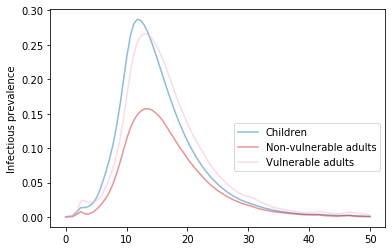

In [10]:
class_per_hh = [children_per_hh, nonv_adults_per_hh, vuln_adults_per_hh]

lgd=['Children','Non-vulnerable adults','Vulnerable adults']

fig, axis = subplots()
cmap = get_cmap('tab20')
alpha = 0.5
for i in range(3):
    axis.plot(
        time, I[:,i]/class_per_hh[i], label=lgd[i],
        color=cmap(i/3), alpha=alpha)
axis.set_ylabel('Infectious prevalence')

axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

fig.show()


To do internal quarantining, we change the model input accordingly, recalculate the household population, and run the model again:

In [11]:
model_input.class_is_isolating = array([[True, True, True],[True, True,True],[True, True, True]])
model_input.iso_method = 1

household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input, within_household_SEPIRQ,6)

rhs = SEPIRQRateEquations(
    model_input,
    household_population,
    import_model,
    epsilon,
    6)

H0 = make_initial_SEPIRQ_condition(household_population, rhs)

tspan = (0.0, no_days)
solver_start = get_time()
solution = solve_ivp(rhs, tspan, H0, first_step=0.001)
solver_end = get_time()

print('Integration completed in', solver_end-solver_start,'seconds.')

time = solution.t
H = solution.y

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:38<00:00,  2.12it/s]


Integration completed in 83.56826829910278 seconds.


Because of the way we code internal quarantine, not everyone in a quarantined household will be in the Q compartment. The actual compartmental structure and rates work exactly as under external quarantining, but we treat any household with Q>0 as being quarantined. What this means is that to work out the total quarantined by class we just do the average number of each class per household over all states with at least one person quarantined.

Note that because of the slightly hacky way we do internal quarantining, we will definitely get indviduals moving into the Q class when their household is already under quarantine. This means some households could end up being under quarantine for longer than they really need to be since successive members could all be triggering their own quarantines but I don't think this is a huge problem since you're unlikely to get more than one or two secondary generations in a household.

In [12]:
S = H.T.dot(household_population.states[:, ::6])
E = H.T.dot(household_population.states[:, 1::6])
P = H.T.dot(household_population.states[:, 2::6])
I = H.T.dot(household_population.states[:, 3::6])
R = H.T.dot(household_population.states[:, 4::6])

states_iso_only = household_population.states[:,5::6]
total_iso_by_state =states_iso_only.sum(axis=1)
iso_present = total_iso_by_state>0
Q = H[iso_present,:].T.dot(household_population.composition_by_state[iso_present,:])

Now plot the new results. The spread appears to be much more controlled but the dynamics are very spiky - possibly because all the households end up very correlated and everyone ends up quarantining in sync with one another.

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


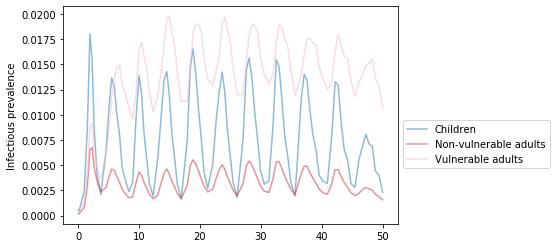

In [14]:
class_per_hh = [children_per_hh, nonv_adults_per_hh, vuln_adults_per_hh]

lgd=['Children','Non-vulnerable adults','Vulnerable adults']

fig, axis = subplots()
cmap = get_cmap('tab20')
alpha = 0.5
for i in range(3):
    axis.plot(
        time, I[:,i]/class_per_hh[i], label=lgd[i],
        color=cmap(i/3), alpha=alpha)
axis.set_ylabel('Infectious prevalence')

axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

fig.show()
